# Financial Fraud Detection

This notebook demonstrates a full machine learning workflow for detecting fraudulent transactions. 
Using a transactional dataset, I perform data cleaning, exploratory data analysis (EDA), and feature engineering 
before training and evaluating classification models. The goal is to identify patterns and anomalies that indicate 
potential fraud, while minimizing false positives to ensure business efficiency.  

Key steps in this notebook:
1. Data inspection and cleaning
2. Exploratory Data Analysis (EDA)
3. Feature selection and engineering
4. Model training (e.g., Logistic Regression, Random Forest)
5. Model evaluation using precision, recall, F1-score, and ROC-AUC

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression

## Load Dataset

In [2]:
data=pd.read_csv('Synthetic_Financial_datasets_log.csv')

In [3]:
df=data.copy()
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


## Initial Cleaning

In [4]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [5]:
df.duplicated().sum()

np.int64(0)

## Explore the Data

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [7]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [8]:
df['type'].value_counts()

type
CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: count, dtype: int64

## Data Cleaning

In [9]:
df = df.drop(['nameOrig', 'nameDest'], axis=1)


In [10]:
df.dtypes

step                int64
type               object
amount            float64
oldbalanceOrg     float64
newbalanceOrig    float64
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object

One-Hot encode 'type' since it is currently a string and cannot be used in modeling so it can add value to prediction.

In [11]:
df = pd.get_dummies(df, columns=['type'], drop_first=True)

In [12]:
df.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,9839.64,170136.0,160296.36,0.0,0.0,0,0,False,False,True,False
1,1,1864.28,21249.0,19384.72,0.0,0.0,0,0,False,False,True,False
2,1,181.00,181.0,0.00,0.0,0.0,1,0,False,False,False,True
3,1,181.00,181.0,0.00,21182.0,0.0,1,0,True,False,False,False
4,1,11668.14,41554.0,29885.86,0.0,0.0,0,0,False,False,True,False


In [13]:
df.dtypes

step                int64
amount            float64
oldbalanceOrg     float64
newbalanceOrig    float64
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
type_CASH_OUT        bool
type_DEBIT           bool
type_PAYMENT         bool
type_TRANSFER        bool
dtype: object

## Explore the Imbalance in Target

Percentage of Transactions that are Fraudulent : 0.1291%


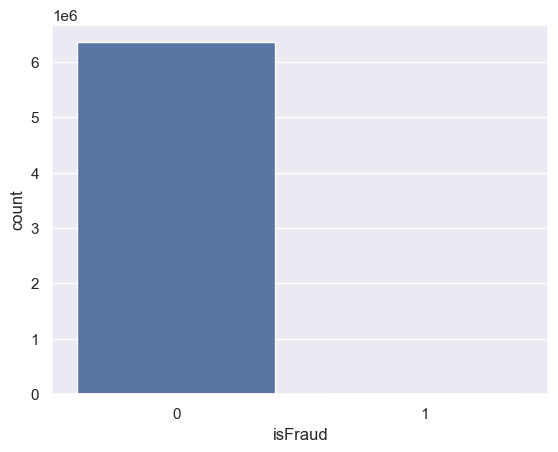

In [14]:
sns.countplot(x='isFraud', data=df)
fraud_percent = df['isFraud'].mean() * 100
print(f"Percentage of Transactions that are Fraudulent : {fraud_percent:.4f}%")


This shows that the data is imbalanced. The next step would be to oversample the minority class.

## Feature Engineering

In [15]:
# define X and y

X = df.drop(['isFraud', 'isFlaggedFraud'], axis=1)
y = df['isFraud']


In [16]:
# scale features

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


## Train-Test Split

In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42)


In [18]:
log_reg = LogisticRegression(class_weight='balanced', max_iter=1000)
log_reg.fit(X_train, y_train)
y_pred_lr = log_reg.predict(X_test)


In [19]:
print("Logistic Regression Report:")
print(classification_report(y_test, y_pred_lr))
print("ROC-AUC:", roc_auc_score(y_test, log_reg.predict_proba(X_test)[:, 1]))


Logistic Regression Report:
              precision    recall  f1-score   support

           0       1.00      0.95      0.97   1270881
           1       0.02      0.96      0.05      1643

    accuracy                           0.95   1272524
   macro avg       0.51      0.96      0.51   1272524
weighted avg       1.00      0.95      0.97   1272524

ROC-AUC: 0.9908334932558942


This report shows that the model is good at finding frauds (0.96 recall), but it also predicts a lot of non-fraud as fraud(0.02
precision). This means that although fraud is being caught, a lot of innocent transactions are also being flagged as fraud.
This also means that accuracy of 95% is inaccurate since the data is heavily imbalanced.

ROC-AUC of 0.9908 is very good. This means that the model is very capable from seperating fraud and non-fraud overall. 

Classifying for 0 vs 1 might not be optimal- try another model.

Use the random forest model, it is better with imbalanced datasets.

## Random forest model

In [20]:
from sklearn.ensemble import RandomForestClassifier

# initialize

rf_clf = RandomForestClassifier(class_weight='balanced', random_state=42, n_estimators=100)

In [21]:
rf_clf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [22]:
# make predictions

y_pred_rf = rf_clf.predict(X_test)
y_pred_rf_proba = rf_clf.predict_proba(X_test)[:, 1]


In [23]:
from sklearn.metrics import classification_report, roc_auc_score

print("Random Forest Report:")
print(classification_report(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_rf_proba))


Random Forest Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.98      0.79      0.87      1643

    accuracy                           1.00   1272524
   macro avg       0.99      0.89      0.94   1272524
weighted avg       1.00      1.00      1.00   1272524

ROC-AUC: 0.9953227937547158


ROC-AUC of 0.995, excellent model performance even before thresholding, which is crucial in fraud detection.

Model predicts fraud correct 98% of the time (precision). The model catched 79% of fraud cases (recall).

In [24]:
df.to_csv('fraud_prediction.csv', sep=';', index=False)